# Bayesian Inference using Flow Matching 

### Simulation Based Inference

Idea basic idea of Simulation Based Inference.

1. **Sample from the prior:** $θ^{(i)} ∼ p(θ)$
    
2. **Simulate Data** $D^{(i)}∼p(D|\theta^{(i)})$ from likelihood given the prior samples.
    
That is two functions need to be specified:

```python
def prior():
    ...
    return theta
```

and 

```python
def simulator(theta):
    ...
    return D
```

### Neural Density Estimation

In the standard neural probabilistic regression setting, we have a neural network that takes in the input $x$ the covariates and outputs the density of the target variable $y$ conditioned on $x$. As in the following figure:

<p align="center">
    <img src="prob_regression.png" width="300px">
</p>

The neural network is trained on training data $(x^{(i)}, y^{(i)})_{i=1}^{N}$ to minimize the negative log likelihood:

$$
    \text{NLL} = - \frac{1}{N} \sum_{i=1}^N \log p(y^{(i)}|x^{(i)})
$$


In the SBI case, we want the neural density to output the posterior density of the parameter $\theta$ conditioned on the data $D$. That is, we want the neural network to output the density $q(\theta|D)$.
<p align="center">
    <img src="SBI.png" width="300px">
</p>

Instead of samples $(x,y)$, we have samples $(D^{(i)}, \theta^{(i)})_{i=1}^{N}$ and $N$ is the number of simulations. 

### Calculate the loss of the approximative posterior $q(\theta^{(i)}|D^{(i)})$. 

Staring from the KL-Divergence between the approximation and the true posterior $D_{KL}(p||q)$, we obtain the loss function 

$$
L(q) = - \frac{1}{N} \sum_{i=1}^N \log (q(D^{(i)}|θ^{(i)})) 
$$

**Note** This is the formaly the same as the negative log likelihood in a regression setting, but instead of the covariates $x$ and observations $y$, we condition on the prior samples $θ^{(i)}$.

**Note** There are variants of SBI, where the actual observed data is taken into account and the sampling is done around regions of high posterior density. This is akin to importance sampling and adjustments need to be made. In the simple approach, we are using here, we are not taking the observed data into account and learn the posterior in a fashion so that it is valid for all possible data. In this context people speak of amortized inference the upfront cost of training the neural network is amortized over all possible data later in the prediction phase.

### Available Neural Density Estimation Techniques

There is an arsenal of neural density estimation techniques available. E.g. Gaussians, Mixture of Gaussians, Normalizing Flows, and the new kid on the block Flow Matching.

In [36]:
import numpy as np
from tqdm import tqdm  # Correct import
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import zuko

### First Example 

We use a pretty simple example to illustrate SBI. The example does not require SBI, but we are free to try it anyway. It's a bit like shooting with a cannon on a sparrow ("Mit Kanonen auf Spatzen schießen" in German).

We assume that our observed data $D$ are unconditional observations $y$ with $y \sim N(\mu, \sigma)$ is generated from a normal distribution with $\theta = (\mu, \sigma)$, where $\mu$ is the mean and $\sigma$ the standard deviation. The prior is a normal distribution with $\mu \sim N(0,5)$ and $\sigma \sim N(0,1)$.

In [37]:
from torch.distributions import Normal

# Define the prior for (mu, sigma)
def prior(num_samples):
    mu = Normal(0, 5).sample((num_samples,))
    sigma = torch.abs(Normal(0, 1).sample((num_samples,)))  # Ensure sigma > 0
    return torch.stack([mu, sigma], dim=1)  # Shape (num_samples, 2)


# Define the simulator (likelihood model)
def simulator(theta):
    mu, sigma = theta[:, 0], theta[:, 1]  # Extract parameters
    y = Normal(mu, sigma).sample()  # Sample from Gaussian
    return y.unsqueeze(-1)  # Shape (num_samples, 1)

In [9]:
# Generate training dataset
num_samples = 10_000  # Number of training samples
theta_samples = prior(num_samples)  # Sample (mu, sigma) from the prior
y_samples = simulator(theta_samples)  # Simulate observations y
theta_samples.shape, y_samples.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

### SBI with Normalizing Flows

100%|██████████| 1000/1000 [00:06<00:00, 160.83it/s]


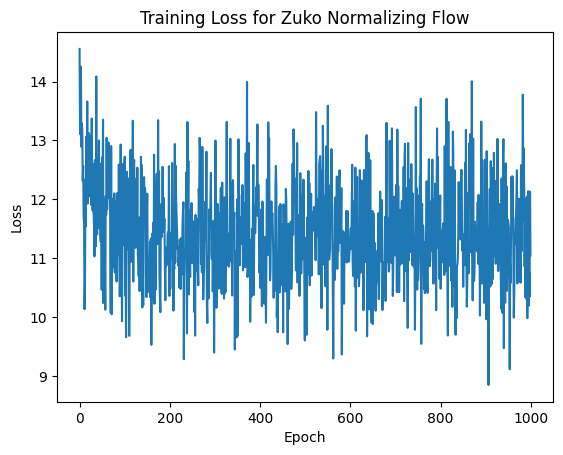

In [40]:
# Neural spline flow (NSF) with input y (context) and output theta (parameters)
flow = zuko.flows.NSF(2, context=1, transforms=3, hidden_features=[128] * 3)

# Define optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
loss_history = []

# Training loop
num_epochs = 1000
batch_size = 512

for epoch in tqdm(range(num_epochs)):
    # Sample a mini-batch
    indices = torch.randint(0, num_samples, (batch_size,))
    theta_batch = theta_samples[indices]  # Parameters
    y_batch = y_samples[indices]  # Corresponding observations

    # Compute loss (negative log-likelihood)
    loss = -flow(y_batch).log_prob(theta_batch).mean()
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

# Plot training loss
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss for Zuko Normalizing Flow")
plt.show()

#### Getting Samples from the flow

We assume a single data observed data point $D=y=1.42$ and use your trained NF to get samples from the posterior $q(\theta|D)$. 

In [43]:
y_obs = 1.42

# Generate posterior samples from Zuko's normalizing flow model
y_obs_tensor = torch.tensor([[y_obs]], dtype=torch.float32)  # Context as tensor
sbi_posterior_samples = flow(y_obs_tensor).sample((5000,)).squeeze(1).detach().numpy()
# Extract mu and sigma from Zuko posterior samples
sbi_mu_samples, sbi_sigma_samples = sbi_posterior_samples[:, 0], sbi_posterior_samples[:, 1]
sbi_mu_samples.shape, sbi_sigma_samples.shape


((5000,), (5000,))

### MCMC Simulation (for comparison) 

The simulation can also be done using the [colab_notebook](https://colab.research.google.com/drive/10_yHnX6es4lQaV5SJ74NBkxJQKQ2aHFl#scrollTo=JOO9OGLG4BIq&uniqifier=1)

In [44]:
stan_code = """
data {
    real y_obs;   // Observed data point
}

parameters {
    real mu;             // Mean parameter
    real<lower=0> sigma; // Standard deviation (must be positive)
}

model {
    // Priors
    mu ~ normal(0, 5);         // Prior: mu ~ N(0,5)
    sigma ~ normal(0, 1);      // Half-Normal prior for sigma

    // Likelihood
    y_obs ~ normal(mu, sigma);
}
"""

# Save to file
with open("gaussian_model.stan", "w") as f:
    f.write(stan_code)

In [48]:
from cmdstanpy import CmdStanModel
model = CmdStanModel(stan_file="gaussian_model.stan")
data = {"y_obs": 1.42}  # Single observation

# Sample from the posterior
fit = model.sample(data=data, chains=4, iter_sampling=50000, iter_warmup=50000, thin = 10)
print(fit.summary())

posterior_samples = fit.draws_pd() # Extract samples
mcmc_mu_samples, mcmc_sigma_samples = posterior_samples["mu"].values, posterior_samples["sigma"].values

13:04:57 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:04:58 - cmdstanpy - INFO - CmdStan done processing.
13:04:58 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 318 divergent transitions (0.6%)
	Chain 2 had 543 divergent transitions (1.1%)
	Chain 3 had 246 divergent transitions (0.5%)
	Chain 4 had 510 divergent transitions (1.0%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.



           Mean      MCSE    StdDev       MAD        5%       50%       95%  \
lp__  -1.015440  0.010053  0.994761  0.691792 -2.963890 -0.707121 -0.092917   
mu     1.359800  0.007096  0.952349  0.539844 -0.217115  1.401680  2.811300   
sigma  0.809061  0.007890  0.588286  0.574424  0.100924  0.686206  1.947440   

       ESS_bulk   ESS_tail    R_hat  
lp__    4752.83   4167.970  1.00083  
mu     18350.60  16413.000  1.00080  
sigma   2366.87    793.019  1.00156  


#### If you don't have a working stan installation

Use the stored posterior samples from the stan simulation.

In [47]:
if False:
    import pandas as pd
    df = pd.read_csv('posterior_samples.csv')
    print(df.head())
    # Load MCMC samples
    df = pd.read_csv('posterior_samples.csv')
    print(f"Loaded {mcmc_mu_samples.shape} MCMC samples")
    mcmc_mu_samples, mcmc_sigma_samples = df["mu"].values, df["sigma"].values

<Figure size 1200x500 with 0 Axes>

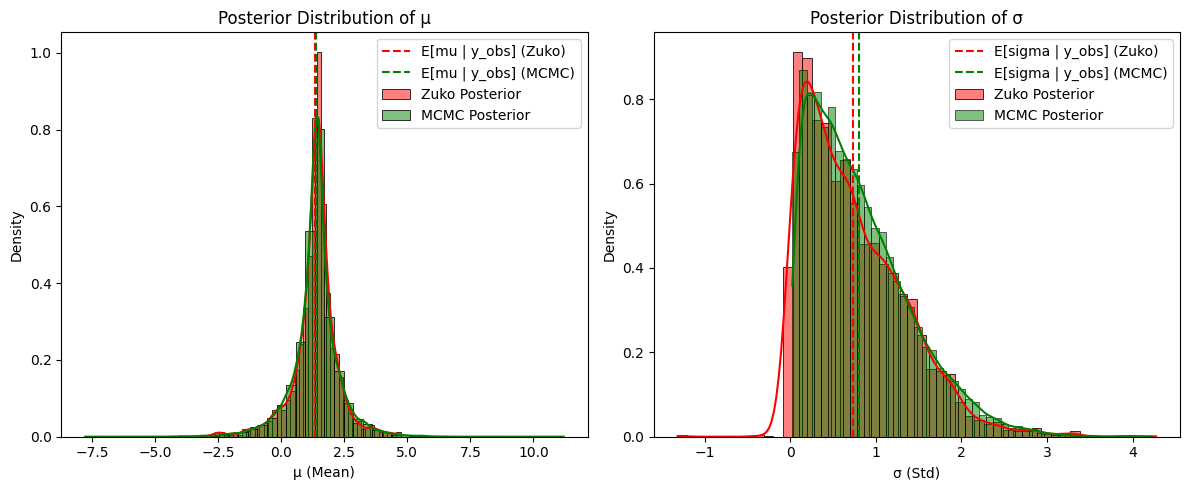

In [49]:
import pandas as pd
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Create the plot
plt.figure(figsize=(12, 5))

# Create the plot
plt.figure(figsize=(12, 5))

# Plot mu distributions
plt.subplot(1, 2, 1)
sns.histplot(sbi_mu_samples, kde=True, stat="density", label="Zuko Posterior", color="red", alpha=0.5, bins=50, common_norm=True)
sns.histplot(mcmc_mu_samples, kde=True, stat="density", label="MCMC Posterior", color="green", alpha=0.5, bins=50, common_norm=True)
plt.axvline(np.mean(sbi_mu_samples), color="red", linestyle="dashed", label="E[mu | y_obs] (Zuko)")
plt.axvline(np.mean(mcmc_mu_samples), color="green", linestyle="dashed", label="E[mu | y_obs] (MCMC)")
plt.xlabel("μ (Mean)")
plt.ylabel("Density")
plt.legend()
plt.title("Posterior Distribution of μ")

# Plot sigma distributions
plt.subplot(1, 2, 2)
sns.histplot(sbi_sigma_samples, kde=True, stat="density", label="Zuko Posterior", color="red", alpha=0.5, bins=50, common_norm=True)
sns.histplot(mcmc_sigma_samples, kde=True, stat="density", label="MCMC Posterior", color="green", alpha=0.5, bins=50, common_norm=True)
plt.axvline(np.mean(sbi_sigma_samples), color="red", linestyle="dashed", label="E[sigma | y_obs] (Zuko)")
plt.axvline(np.mean(mcmc_sigma_samples), color="green", linestyle="dashed", label="E[sigma | y_obs] (MCMC)")
plt.xlabel("σ (Std)")
plt.ylabel("Density")
plt.legend()
plt.title("Posterior Distribution of σ")

plt.tight_layout()
plt.show()

### Neural Density Estimation with Flow Matching

Here, we really do an overkill and use the flow matching technique to estimate the posterior.

#### Definition of the NN model
Here we use the sample model as in the flow matching example [Flow_Matching.ipynb](Flow_Matching.ipynb).

In [50]:
import math
import torch
import torch.nn as nn

class Block(nn.Module):
    def __init__(self, channels=512):
        super().__init__()
        self.ff = nn.Linear(channels, channels)
        self.act = nn.ReLU()

    def forward(self, x):
        return self.act(self.ff(x))

class MLP(nn.Module):
    def __init__(self, channels_data=2, layers=5, channels=512, channels_t=512):
        super().__init__()
        self.channels_t = channels_t
        self.in_projection = nn.Linear(channels_data, channels)
        self.t_projection = nn.Linear(channels_t, channels)
        self.blocks = nn.Sequential(*[Block(channels) for _ in range(layers)])
        self.out_projection = nn.Linear(channels, channels_data)

    def gen_t_embedding(self, t, max_positions=10_000):
        """
        Generates sinusoidal time embeddings.
        t: (batch, 1) tensor of time steps.
        Returns: (batch, channels_t) tensor.
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1) # Ensure shape (batch, 1)
        t = t * max_positions
        half_dim = self.channels_t // 2
        emb_scale = math.log(float(max_positions) + 1e-8) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device, dtype=torch.float32) * -emb_scale)
        emb = t * emb  # (batch, half_dim)

        # Compute sinusoidal embeddings
        emb = torch.cat([emb.sin(), emb.cos()], dim=1)  # (batch, channels_t)
        
        # If channels_t is odd, pad the embedding with zero
        if self.channels_t % 2 == 1:
            emb = nn.functional.pad(emb, (0, 1), mode='constant', value=0)
        
        return emb

    def forward(self, x, t):
        """
        Forward pass of MLP.
        x: (batch, channels_data) input data.
        t: (batch, 1) time step input.
        """
        if t.dim() == 1:
            t = t.unsqueeze(-1)  # Ensure shape (batch, 1)

        x = self.in_projection(x)  # (batch, channels)
        t_emb = self.gen_t_embedding(t)  # (batch, channels_t)
        t_emb = self.t_projection(t_emb)  # (batch, channels)

        x = x + t_emb  # Combine time and input embeddings
        x = self.blocks(x)
        x = self.out_projection(x)  # (batch, channels_data)

        return x

## Training Loop

# TODO Baustelle weitermachen

In [ ]:
import torch
import tqdm

# Constants
SIGMA_MIN = 1e-4
TRAINING_STEPS = 1500
BATCH_SIZE = 256
LEARNING_RATE = 1e-5

# Initialize model and optimizer
model = MLP(layers=5, channels=512)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# Load data
data = y_obs

# Training loop
losses = []
pbar = tqdm.tqdm(range(TRAINING_STEPS), desc="Training Progress")

for _ in pbar:
    # Sample batch
    indices = torch.randint(data.size(0), (BATCH_SIZE,))
   
    t = torch.rand(BATCH_SIZE, 1, device=data.device)  # t ~ Uniform(0,1), Shape: (BATCH_SIZE, 1)

    ### Loss as in Davids paper
    #z1 = prior_samples(BATCH_SIZE)  # Shape: (BATCH_SIZE, 2)
    #d = simulator(z1)  # Shape: (BATCH_SIZE, 1)
    #zt = (1. - (1. - SIGMA_MIN)*t) * z0 + t * z1  # Shape: (BATCH_SIZE, 2)
    #u_t = (z1 - (1 - SIGMA_MIN) * z0) / (1 - (1 - SIGMA_MIN) * t)  # Target velocity, Shape: (BATCH_SIZE, 2)
    #pred = model(zt, t) # Shape: (BATCH_SIZE, data_dim)
    #loss = ((u_t - pred) ** 2).mean()

    ### Loss as SBI in Schölkopf paper
    # See also: https://github.com/dingo-gw/flow-matching-posterior-estimation/blob/main/sbi-benchmark/run_sbibm.py
    
    # At t = 1
    # theta_1 = prior_samples(BATCH_SIZE)   # Sampling from Prior see paper
    # ys = likelihood_samples(theta_1)      # Simulating data corresponding to theta
    # # Preparing for t=t 
    # mu_t = theta_1 * t
    # sigma_t = 1 - (1 - SIGMA_MIN) * t  # Shape: (BATCH_SIZE, data_dim)
    # theta_t = mu_t + sigma_t * torch.randn_like(mu_t) 
    # u_t = (theta_1 - (1 - SIGMA_MIN) * theta_t) / (1 - (1 - SIGMA_MIN) * t) 
    # pred = model(theta_t, t) # Shape: (BATCH_SIZE, data_dim)
    # loss = ((u_t - pred) ** 2).mean()
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Logging
    pbar.set_postfix(loss=loss.item())
    losses.append(loss.item())

NameError: name 'y' is not defined

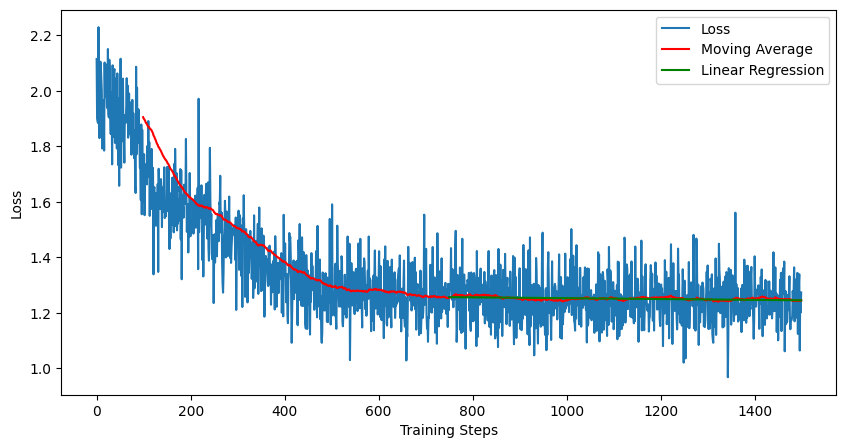

array([-1.53556874e-05])

In [ ]:
from sklearn.linear_model import LinearRegression
import pandas as pd

# Calculate moving average
window_size = 100
losses_series = pd.Series(losses)
moving_avg = losses_series.rolling(window=window_size).mean()

# Plot the losses and moving average
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.plot(moving_avg, label='Moving Average', color='red')

# Linear regression on the last 50% of the iterations
half_index = len(losses) // 2
x_vals = np.arange(half_index, len(losses)).reshape(-1, 1)
y_vals = losses[half_index:]

reg = LinearRegression().fit(x_vals, y_vals)
y_pred = reg.predict(x_vals)

plt.plot(x_vals, y_pred, label='Linear Regression', color='green')

plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()
reg.coef_




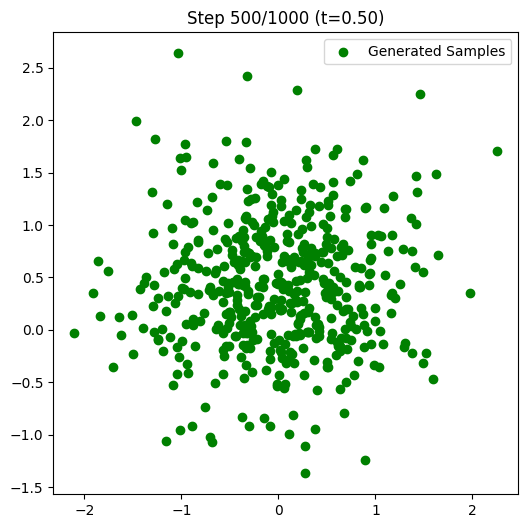

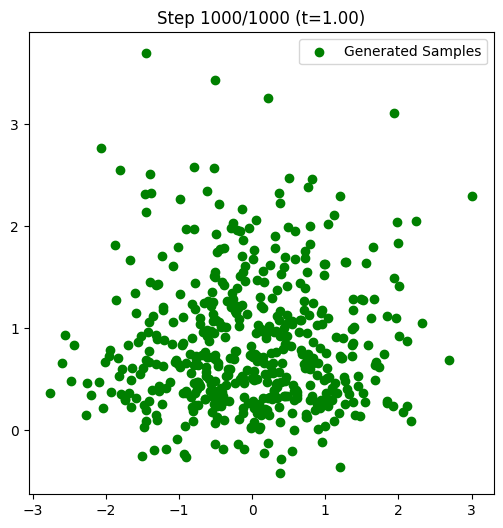

Done Sampling
Mean x:  tensor(-0.0329)
Mean x:  tensor(0.8339)


In [13]:
import torch
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)
xt = torch.randn(500, 2)
steps = 1000
plot_every = 500
with torch.no_grad():
    for i, t in enumerate(torch.linspace(0, 1, steps), start=1):
        t = t.view(-1, 1).expand(xt.size(0), 1)  # Ensure (batch, 1) shape
        pred = model(xt, t)  # Predict velocity
        xt = xt + (1 / steps) * pred  
        
        # Plot results at intervals
        if i % plot_every == 0 or i == steps or i == 0:
            plt.figure(figsize=(6, 6))
            #plt.scatter(sampled_points[:, 0], sampled_points[:, 1], color="red", marker="o", label="Real Data")
            plt.scatter(xt[:, 0], xt[:, 1], color='green', marker="o", label="Generated Samples")
            plt.title(f"Step {i}/{steps} (t={t.mean().item():.2f})")
            plt.legend()
            plt.show()


print("Done Sampling")
print("Mean x: ", xt[:,0].mean())
print("Mean x: ", xt[:,1].mean())


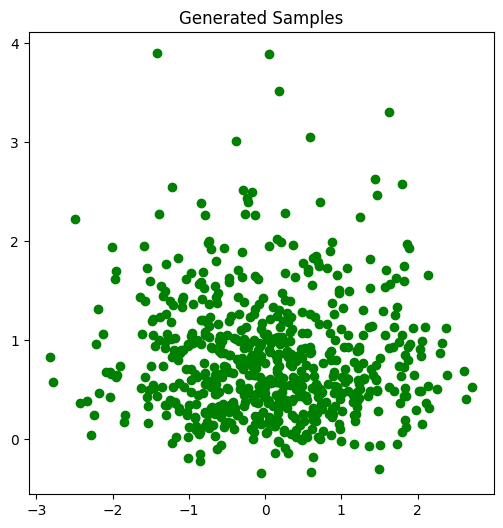

tensor([0.0334, 0.6770])

In [15]:
import torch
import torchdiffeq
import matplotlib.pyplot as plt

@torch.no_grad()
def sample_flow(model, x_0, steps=5, method="euler"):
    """
    Uses an ODE solver to integrate the learned velocity field.
    
    model: Neural network predicting v_t(x).
    x_0: Initial noise sample.
    steps: Number of integration steps.
    method: ODE solver method (e.g., "euler", "rk4", "dopri5", "bdf").
    
    Returns: Generated sample x_1.
    """
    def velocity_field(t, x_t):
        """
        Compute velocity at given time step.
        
        - t: Scalar time step.
        - x_t: Tensor of shape (batch_size, dim).
        """
        # Ensure x_t always has shape (batch_size, dim)
        if x_t.ndim == 1:
            x_t = x_t.unsqueeze(0)  # Ensure batch size

        # Ensure t is a tensor of correct shape (batch_size, 1)
        t_tensor = torch.full((x_t.shape[0], 1), t.item(), device=x_t.device, dtype=x_t.dtype)

        # Compute velocity
        v_t = model(x_t, t_tensor)  # Ensure model output matches (batch_size, dim)
        return v_t

    # Define the time grid (descending order for reverse integration)
    t_eval = torch.linspace(0, 1, steps, device=x_0.device)

    # Solve the ODE using the chosen method
    x_trajectory = torchdiffeq.odeint(velocity_field, x_0, t_eval, method=method)

    # Return the final sample (last time step)
    x_1 = x_trajectory[-1]  # Shape: (batch_size, dim)

    return x_1

# Example: Generate samples using Euler method
x_0 = torch.randn(640, 2)  # Start from Gaussian noise
x_sampled = sample_flow(model, x_0, method="rk4", steps=100)

# Plot the generated samples
plt.figure(figsize=(6, 6))
plt.scatter(x_sampled[:, 0].cpu(), x_sampled[:, 1].cpu(), color="green", marker="o")
plt.title("Generated Samples")
plt.show()

# Median and robust standard deviation
x_sampled.median(dim=0).values
